# Get wallets that chose to pay full royalties on Illuminati NFT sales 

- Proof of Concept to track full royalty payers for potential rewards using the [Illuminati NFT collection](https://opensea.io/collection/illuminaticollective).
- This can expand and generalize to other collections and uses. 

- Data is from [Reservoir](https://reservoir.tools).
- Output of royalty payers [here](https://docs.google.com/spreadsheets/d/1V60UP4NDBkU4vud6YrBHYwxh0YURlkw82UHV6Usk_zo/edit?usp=sharing).

## More Details
- Only tracks seller royalty decisions since buyers currently don't control royalties on OS/Blur (and this collection isn't on Sansa).
- Only counts full royalty sales after OpenSea made them optional on the old Illuminati contract (since the new one enforces royalties).
- Adds info on which royalty payers still hold Illuminati NFTs (using the new contract).

In [1]:
import requests
import os
import logging
import sys
import datetime

import pandas as pd
import numpy as np

from dotenv import load_dotenv, find_dotenv

In [2]:
# Configure logging output for Jupyter notebook cells.
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [3]:
# Finds .env and loads entries as environment variables.
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

True

#### Collection Sales and Royalty Info

In [4]:
def fetch_sales_for_a_contract_from_reservoir(contract: str, start_timestamp: float = None, 
                                              max_runs: int = 10) -> pd.DataFrame:
    ''' Fetches all sales for a contract from resorvoir, including royalty info.
    
    This endpoint limits results so it continues until it gets all or reaches max runs.
    '''
    url = 'https://api.reservoir.tools/sales/v5'

    headers = {
        'accept': '*/*',
        'x-api-key': os.environ.get('RESERVOIR_API_KEY')
    }

    params = {
        'contract' : contract,
        'limit' : 1000 # This endpoint's max results.
    }
    
    if start_timestamp is not None:
        params['startTimestamp'] = start_timestamp
    
    responses = []
    
    response = requests.get(url, headers=headers, params=params).json()
    response_df = pd.DataFrame(response['sales'])
    responses.append(response_df)

    logging.info(f'Completed first run for {contract}')
    
    # This endpoint limits results returned. If there are more, it iterates through 
    # all continuation tokens are handled or until the max number of runs. 
    run_counter = 0
    while True:
        if response['continuation'] is None:
            break
        params['continuation'] = response['continuation']
        response = requests.get(url, headers=headers, params=params).json()
        response_df = pd.DataFrame(response['sales'])
        responses.append(response_df)
        run_counter += 1
        logger.info(f'Completed continuation run #{run_counter}')
        if run_counter >= max_runs:
            logger.warning(f'Maximum number of runs ({max_runs}) reached')
            break

    df = pd.concat(responses)
    
    df['block_time'] = pd.to_datetime(df.timestamp, unit='s')
    
    # Summarize fetched sales data.
    n_sales = len(df)
    first_sale_date = df.block_time.min()
    last_sale_date = df.block_time.max()

    logging.info(f'Fetched a total of {n_sales} sales')
    logging.info(f'These sales took place from {first_sale_date} to {last_sale_date}')
    
    return df


def summarize_seller_royalty_behavior_by_wallet(sales):
    '''Aggretales sales stats and transaction hashes by royalty status for each wallet's selling.
    
    Only tracks seller's royalties since sellers set royalties on large markets.
    '''
    sales.paidFullRoyalty.fillna(False, inplace=True)
    
    # Add two columns for txn hashes based on royalty status (full or not).
    # Use these in aggregation to document txns by their royalty status for manual QA later. 
    # To-do: clean up txn hash storing code.
    sales['fullRoyaltyTxHash'] = ""
    sales['missingRoyaltyTxHash'] = ""
    sales.loc[sales.paidFullRoyalty, 'fullRoyaltyTxHash'] = sales.loc[sales.paidFullRoyalty, 'txHash']
    sales.loc[~sales.paidFullRoyalty, 'missingRoyaltyTxHash'] = sales.loc[~sales.paidFullRoyalty, 'txHash']
    
    
    royalty_summary = (sales.groupby('from').agg(
        full_royalty_rate = ('paidFullRoyalty',np.mean),
        full_royalty_sales = ('paidFullRoyalty',np.sum),
        total_sales = ('paidFullRoyalty',len),
        full_royalty_txns=('fullRoyaltyTxHash', lambda x: ', '.join(filter(None, x))),
        missing_royalty_txns=('missingRoyaltyTxHash', lambda x: ', '.join(filter(None, x)))
        )
    )
    
    royalty_summary = royalty_summary.reset_index().rename(columns={'from':'address'})
    
    # Dedupes transaction hashes. A bit slow and inelegant, but works.
    royalty_summary.full_royalty_txns = (royalty_summary.full_royalty_txns
                                         .str.split(', ')
                                         .map(set)
                                         .map(lambda x: ', '.join(x))
        )
    royalty_summary.missing_royalty_txns = (royalty_summary.missing_royalty_txns
                                            .str.split(', ')
                                            .map(set)
                                            .map(lambda x: ', '.join(x))
        )
    
    # Add categorical summary of royalty behavior.
    royalty_summary['royalty_status'] = np.nan
    royalty_summary.loc[royalty_summary.full_royalty_rate == 1, 'royalty_status'] = 'Always Paid Full'
    royalty_summary.loc[royalty_summary.full_royalty_rate == 0, 'royalty_status'] = 'Never Paid Full'
    royalty_summary.loc[(royalty_summary.full_royalty_rate > 0)
                        &(royalty_summary.full_royalty_rate < 1), 'royalty_status'] = 'Mixed: Some Full, Not All'
    
    # Calculate number of sales without full royalties. 
    royalty_summary['non_full_royalty_sales'] = royalty_summary['total_sales'] - royalty_summary['full_royalty_sales']
 
    # Log some summary stats.
    n_wallets = len(royalty_summary)
    logging.info(f'Summarized seller royalty behavior for {n_wallets} wallets')

    return royalty_summary

#### Holders and Output 

In [5]:
def fetch_current_holders_for_a_contract_from_reservoir(contract : str,
                                                        max_runs: int = 10) -> pd.DataFrame:
    ''' Fetches wallets currently holding NFTs of given contract from resevoir.  
    
    This endpoint limits results so it continues until it gets all or reaches max runs.
    '''
    url = "https://api.reservoir.tools/owners/v2"
    # This endpoint's max.
    limit = 500

    headers = {
        'accept': '*/*',
        'x-api-key': os.environ.get('RESERVOIR_API_KEY')
    }

    params = {
        'contract' : contract,
        'limit' :  limit 
    }
    
    responses = []
    
    response = requests.get(url, headers=headers, params=params).json()
    response_df = pd.DataFrame(response['owners'])
    responses.append(response_df)

    logging.info(f'Completed first run for {contract} holders')
    
    # This endpoint limits results returned. If there are more (i.e. past request returned full limit), 
    # it iterates until it gets all or to the max number of runs. 
    run_counter = 0
    while True:
        # If returned results are below API's limit, we got everything.
        if len(response_df) < limit:
            break
        params['offset'] = run_counter * limit + len(response_df)
        logging.debug(params['offset'])
        response = requests.get(url, headers=headers, params=params).json()
        response_df = pd.DataFrame(response['owners'])
        responses.append(response_df)
        run_counter += 1
        logger.info(f'Completed continuation run #{run_counter}')
        if run_counter >= max_runs:
            logger.warning(f'Maximum number of runs ({max_runs}) reached')
            break
    
    df = pd.concat(responses)
    
    # Adds today's date as a snapshot date for holdings.
    df['snapshot_date'] = datetime.date.today()
    
    n_holders = len(df)
    logging.info(f'Fetched a total of {n_holders} holders')
    
    return df


def clean_holders_data(holders):
    '''Cleans holder data by extracting tokens held from a JSON column and removes unneeded columns.'''
    
    holders['tokens'] = holders['ownership'].map(lambda x: x['tokenCount']).astype(float)
    
    logging.info(f'Cleaned holder data')
    
    return holders[['address','tokens','snapshot_date']]


def add_holder_data_to_royalty_summary(royalty_summary, holders):
    ''' Adds holder info from snapshot to royalty summary.'''
    
    royalty_summary = royalty_summary.merge(
        holders,
        how='left',
        on='address'
    )

    # Cleans royalty summary for non-holders by filling nulls.
    
    # Sellers with no holdings at snapshot have 0.
    royalty_summary.tokens = royalty_summary.tokens.fillna(0)
    
    # Extract snapshot date to fill for nulls.
    snapshot_date = royalty_summary.snapshot_date.dropna().iloc[0]
    royalty_summary.snapshot_date = royalty_summary.snapshot_date.fillna(snapshot_date)
    
    # Add a binary category for holdership.
    royalty_summary['holder_status'] = np.where(royalty_summary.tokens > 0, 'Holder', 'Non-Holder')
    
    logging.info(f'Added holder data to royalty summary')
    
    return royalty_summary


def save_csv_locally(df, project_folder, dataset_name):
    '''Saves dataframe locally as a csv'''

    directory = f'data/{project_folder}'
    filename = f'{dataset_name}.csv'
    path = f'{directory}/{filename}'
    
    if not os.path.exists(directory):
        os.makedirs(directory)
        logging.info(f'Created directory: {directory}')
    
    df.to_csv(path, index=False)
    logging.info(f'Saved csv with output data locally at {path}')


def clean_and_save_output(royalty_summary, project_folder):
    '''Filters data for output and saves as a local CSV in project folder.'''
    
    # Output is limited to wallets with at least one full royalty sale.
    output = royalty_summary[royalty_summary.full_royalty_sales >= 1]
    
    # Sort by royalty and holder status.
    royalty_summary = royalty_summary.sort_values(['royalty_status','holder_status'])
    
    # Log some summary stats.
    n_wallets = len(royalty_summary)
    n_royalty_payers = len(output)
    percent_royalty_payers = round((n_royalty_payers / n_wallets) * 100, 1)
    
    logging.info(f'There are {n_wallets} wallets that sold an NFT')
    logging.info(f'Only {n_royalty_payers} wallets paid full royalties on 1+ sales')
    logging.info(f'{percent_royalty_payers}% of wallets paid full royalties on 1+ sales')
    logging.info('Output is for wallets with 1+ full royalty sales')
    
    # Rename columns for output.
    output_col_names = {
        'address' : 'Wallet',
        'royalty_status' : 'Royalty Status',
        'holder_status' : 'Holder Status',
        'full_royalty_rate' : 'Percent of Sales for Full Royalties',
        'full_royalty_sales' : 'Full Royalty Sales',
        'non_full_royalty_sales' : 'Non-Full Royalty Sales',
        'total_sales' : 'Total Sales',
        'tokens' : 'Illuminati Tokens Held on Snapshot Date',
        'snapshot_date' : 'Snapshot Date',
        'full_royalty_txns' : 'Tx Hashes for Full Royalties',
        'missing_royalty_txns' : 'Tx Hashes for Non-Full Royalties'

    }
    output_cols = ['Wallet','Percent of Sales for Full Royalties','Royalty Status','Holder Status', 
                   'Full Royalty Sales', 'Non-Full Royalty Sales', 'Total Sales',
                   'Illuminati Tokens Held on Snapshot Date', 'Snapshot Date', 
                   'Tx Hashes for Full Royalties','Tx Hashes for Non-Full Royalties']

    output = output.rename(columns=output_col_names)[output_cols]
    
    logging.info(f'Prepared royalty summary for output')
    
    save_csv_locally(output, project_folder=project_folder, dataset_name='output')
    
    return output

In [6]:
# Use old contract (when royalties were optional) for sales.
# Use new contract to see who still holds illuminati assets.
contract_old = '0x26BAdF693F2b103B021c670c852262b379bBBE8A' # Old Illuminati contract
contract_new = '0x8CB05890B7A640341069fB65DD4e070367f4D2E6' # New Illuminati contract

# OpenSea made royalties optional on Feb 17, 2023.
start_date = '2023-02-18'
start_timestamp = datetime.datetime.strptime(start_date, "%Y-%m-%d").timestamp()

# Limit on continuation runs for fetching data from APIs with limits.
max_runs = 10

# Local folder to store royalty payers and interim data as csv's.
today_str = "{:%Y%m%d}".format(datetime.date.today())
project_folder = f'illuminati_royalty_payers_{today_str}'

In [7]:
sales = fetch_sales_for_a_contract_from_reservoir(contract=contract_old, start_timestamp=start_timestamp, 
                                                  max_runs=max_runs)
sales.info()

2023-05-05 14:26:01,011 - root - INFO - Completed first run for 0x26BAdF693F2b103B021c670c852262b379bBBE8A
2023-05-05 14:26:01,031 - root - INFO - Fetched a total of 629 sales
2023-05-05 14:26:01,032 - root - INFO - These sales took place from 2023-02-18 05:16:47 to 2023-04-16 14:52:47
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 629 non-null    object        
 1   saleId             629 non-null    object        
 2   token              629 non-null    object        
 3   orderId            629 non-null    object        
 4   orderSource        629 non-null    object        
 5   orderSide          629 non-null    object        
 6   orderKind          629 non-null    object        
 7   from               629 non-null    object        
 8   to                 629 non-null    object        
 9 

In [8]:
sales.head()

,id,saleId,token,orderId,orderSource,orderSide,orderKind,from,to,amount,...,price,washTradingScore,royaltyFeeBps,paidFullRoyalty,feeBreakdown,isDeleted,createdAt,updatedAt,marketplaceFeeBps,block_time
0,299c30a35eb9c1f4e6388bf9828d27d31861929ac33f7e...,09fdf3591cd7af8eb33972fa9d4237238c199399a3e3c0...,{'contract': '0x26badf693f2b103b021c670c852262...,0x1b8aa15ba9b05d8071c92e191c35e48fee7c0e4e43a6...,gem.xyz,bid,seaport-v1.4,0x2acf5053b707a4fc7d568f98fe8161aaa4e74cc3,0xf7a5aa94fdd3049d1fd78b69863282c4f4ff686b,1,...,{'currency': {'contract': '0xc02aaa39b223fe8d0...,0,500.0,True,"[{'kind': 'royalty', 'bps': 500, 'recipient': ...",False,2023-04-16T14:53:03.388Z,2023-04-16T14:54:21.392Z,NaN,2023-04-16 14:52:47
1,91dd14bf5beef3a6489f1b5a2e40cc26430e09ba6c9b08...,ad6fed82413400a667a10cc655b4a46b3a88a4762e1063...,{'contract': '0x26badf693f2b103b021c670c852262...,0xe538c16e143ebb2d11ba2b2b2e0739ec501821da5acd...,gem.xyz,bid,seaport-v1.4,0x15fca867b0521995dba0525cb3ec8e281b9a5807,0xf7a5aa94fdd3049d1fd78b69863282c4f4ff686b,1,...,{'currency': {'contract': '0xc02aaa39b223fe8d0...,0,500.0,True,"[{'kind': 'royalty', 'bps': 500, 'recipient': ...",False,2023-04-16T14:10:28.645Z,2023-04-16T14:11:29.852Z,NaN,2023-04-16 14:10:23
2,07c00b4d54b587a26b60123c375ff072d1691210d022ae...,ca9d7a8816e16caee511491e1c1055942dda2ced1da495...,{'contract': '0x26badf693f2b103b021c670c852262...,0x6519474fca850f5bbb3c83f80bba186de0ea8beac76c...,looksrare.org,bid,looks-rare-v2,0xb055da94fd9ae45fe518da738d5c8da92ab1138f,0xedbe6ed3426e6c12bf1d1cd4ba06cc620d0800f1,1,...,{'currency': {'contract': '0xc02aaa39b223fe8d0...,0,50.0,NaN,"[{'kind': 'royalty', 'bps': 50, 'recipient': '...",False,2023-04-16T13:31:51.479Z,2023-04-16T13:33:05.107Z,NaN,2023-04-16 13:31:47
3,3234b3821b2b408891a88bd0d7e3110559cac80159b496...,3ecf8eb299bde9097a1aa516aaf8023bbb302f6aeca4d1...,{'contract': '0x26badf693f2b103b021c670c852262...,0xd100fa8d62cd497a8c0904477a7cd3c44072035e8230...,blur.io,bid,blur,0x58454e733bf7d5999607c0e777a9a4df00d60d82,0x1c8f86d7647a9510fc715612c440a6c010c25b82,1,...,{'currency': {'contract': '0x00000000000000000...,0,50.0,NaN,"[{'kind': 'royalty', 'bps': 50, 'recipient': '...",False,2023-04-13T14:05:48.646Z,2023-04-13T14:06:43.769Z,NaN,2023-04-13 14:05:35
4,ba0742d5610d250675531f961cb60c0dcecc873b143fac...,1638de1b5eb631d5f00069f086a801992215bff7eb9604...,{'contract': '0x26badf693f2b103b021c670c852262...,0x06b9f04f1b0a851095c151ece9e48bb211476802482c...,opensea.io,ask,seaport-v1.4,0xeaeaa1e30d62bea880d5f38171bb32a2f91bfdce,0x53ed9466627eae9abe3b4cb1bcbc309cbe0e967b,1,...,{'currency': {'contract': '0x00000000000000000...,0,50.0,NaN,"[{'kind': 'royalty', 'bps': 50, 'recipient': '...",False,2023-04-13T13:00:30.279Z,2023-04-13T13:01:28.920Z,NaN,2023-04-13 13:00:11


In [9]:
royalty_summary = summarize_seller_royalty_behavior_by_wallet(sales)
royalty_summary.head()

2023-05-05 14:26:01,247 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2023-05-05 14:26:01,256 - root - INFO - Summarized seller royalty behavior for 326 wallets


,address,full_royalty_rate,full_royalty_sales,total_sales,full_royalty_txns,missing_royalty_txns,royalty_status,non_full_royalty_sales
0,0x00a70ab9b77a1c21f16501498af910797959b234,0.0,0,1,,0xf683febc3704d1403b08e30a341e16663bc5326beaf4...,Never Paid Full,1
1,0x00c954196d618e4e67d0d0fbfc4bc63e1c3ed857,0.0,0,3,,0x8f1defbb3464386433c8163105c095e7efab30aa5d74...,Never Paid Full,3
2,0x02ee0381eed17fd16cfe682d132f173b5d531805,1.0,1,1,0x8ed47a5cad16b902a3378b9345811b3c79fe224530dc...,,Always Paid Full,0
3,0x049cd1f76d337179d0660d6bcbbf7d3b04f4055e,0.0,0,1,,0xae12ad076c25eac1c7b3588cd33bdc110ff3c8070831...,Never Paid Full,1
4,0x0551eec9820a6cd9fcbc10526c09f3f659a9b8f8,0.0,0,1,,0x87cb6bc7f7acd652585f3151be20a9f4849d2fa84153...,Never Paid Full,1


In [10]:
holders = fetch_current_holders_for_a_contract_from_reservoir(contract=contract_old, 
                                                              max_runs=max_runs)
holders = clean_holders_data(holders)
holders.info()

2023-05-05 14:26:02,038 - root - INFO - Completed first run for 0x26BAdF693F2b103B021c670c852262b379bBBE8A holders
2023-05-05 14:26:02,490 - root - INFO - Completed continuation run #1
2023-05-05 14:26:03,385 - root - INFO - Completed continuation run #2
2023-05-05 14:26:04,070 - root - INFO - Completed continuation run #3
2023-05-05 14:26:04,835 - root - INFO - Completed continuation run #4
2023-05-05 14:26:05,103 - root - INFO - Completed continuation run #5
2023-05-05 14:26:05,341 - root - INFO - Completed continuation run #6
2023-05-05 14:26:05,548 - root - INFO - Completed continuation run #7
2023-05-05 14:26:05,557 - root - INFO - Fetched a total of 3525 holders
2023-05-05 14:26:05,563 - root - INFO - Cleaned holder data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3525 entries, 0 to 24
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        3525 non-null   object 
 1   tokens         3525 no

In [11]:
royalty_summary = add_holder_data_to_royalty_summary(royalty_summary, holders)

2023-05-05 14:26:05,599 - root - INFO - Added holder data to royalty summary


In [12]:
output = clean_and_save_output(royalty_summary, project_folder=project_folder)

2023-05-05 14:26:05,633 - root - INFO - There are 326 wallets that sold an NFT
2023-05-05 14:26:05,638 - root - INFO - Only 99 wallets paid full royalties on 1+ sales
2023-05-05 14:26:05,638 - root - INFO - 30.4% of wallets paid full royalties on 1+ sales
2023-05-05 14:26:05,638 - root - INFO - Output is for wallets with 1+ full royalty sales
2023-05-05 14:26:05,671 - root - INFO - Prepared royalty summary for output
2023-05-05 14:26:05,691 - root - INFO - Saved csv with output data locally at data/illuminati_royalty_payers_20230505/output.csv


In [13]:
# Stores other datasets locally for auditing (move to cloud for anything used in production).
save_csv_locally(sales, project_folder=project_folder, dataset_name='sales')
save_csv_locally(royalty_summary, project_folder=project_folder, dataset_name='royalty_summary')
save_csv_locally(holders, project_folder=project_folder, dataset_name='holders')

2023-05-05 14:26:05,729 - root - INFO - Saved csv with output data locally at data/illuminati_royalty_payers_20230505/sales.csv
2023-05-05 14:26:05,733 - root - INFO - Saved csv with output data locally at data/illuminati_royalty_payers_20230505/royalty_summary.csv
2023-05-05 14:26:05,749 - root - INFO - Saved csv with output data locally at data/illuminati_royalty_payers_20230505/holders.csv


# Analysis

### Summary Stats

* Most didn't pay full royalties on Illuminati sales during this time
    * Only 21% of sales included full royalties
    * Only 30% of wallets (99 of 326) paid full royalties at least once when selling 
* Of the 99 wallets with at least one full royalty sale, most always paid full royalties, but not all
    * 83% of them paid full royalties on all Illuminati sales 
    * 17% were mixed: they paid full royalties on some sales, but not all
* Some royalty payers are still holders, but most aren't because this is based on selling 
    * Only 31% of royalty payers still hold any Illuminati as of 5/5/23

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [15]:
plt.style.use('fivethirtyeight')
plt.rcParams["axes.grid.axis"] ="y"

plt.rcParams["axes.edgecolor"] = '#cbcbcb'#'.15'
plt.rcParams["axes.linewidth"] = 2.0
plt.rcParams["figure.facecolor"] = 'white'
plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams["axes.spines.bottom"] = True
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.right"] = False


In [16]:
sales['Royalty Rate'] = sales.royaltyFeeBps/100
sales['Royalty Status'] = np.where(sales.paidFullRoyalty,'Full Royalty', 'Not Full Royalty')

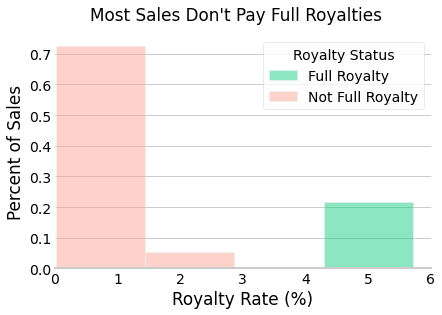

In [17]:
palette = {
    'Full Royalty' :'#1acf85',
    'Not Full Royalty' :'#fda697'
}

sns.histplot(sales, x='Royalty Rate', stat='probability', bins=10,hue='Royalty Status',palette=palette);
plt.xlim(0,6);
plt.suptitle('Most Sales Don\'t Pay Full Royalties');
plt.ylabel('Percent of Sales');
plt.xlabel('Royalty Rate (%)');

In [18]:
sales.paidFullRoyalty.value_counts(normalize=True).round(2)

False    0.79
True     0.21
Name: paidFullRoyalty, dtype: float64

In [19]:
sales.paidFullRoyalty.value_counts()


False    497
True     132
Name: paidFullRoyalty, dtype: int64

In [20]:
len(sales)

629

In [21]:
royalty_summary.royalty_status.value_counts(normalize=True).round(2)

Never Paid Full              0.70
Always Paid Full             0.25
Mixed: Some Full, Not All    0.05
Name: royalty_status, dtype: float64

In [22]:
royalty_summary.royalty_status.value_counts()

Never Paid Full              227
Always Paid Full              82
Mixed: Some Full, Not All     17
Name: royalty_status, dtype: int64

In [23]:
royalty_summary.groupby(['royalty_status','holder_status']).size().unstack(level=1)

holder_status,Holder,Non-Holder
royalty_status,,
Always Paid Full,23,59
"Mixed: Some Full, Not All",8,9
Never Paid Full,59,168


In [24]:
pd.crosstab(royalty_summary.holder_status,
            royalty_summary.royalty_status,
            normalize='index')

royalty_status,Always Paid Full,"Mixed: Some Full, Not All",Never Paid Full
holder_status,,,
Holder,0.255556,0.088889,0.655556
Non-Holder,0.250000,0.038136,0.711864


In [25]:
royalty_summary.royalty_status.value_counts()

Never Paid Full              227
Always Paid Full              82
Mixed: Some Full, Not All     17
Name: royalty_status, dtype: int64

In [26]:
royalty_payers = royalty_summary[royalty_summary.full_royalty_sales >= 1]


In [27]:
royalty_payers.non_full_royalty_sales.value_counts(normalize=True).sort_index().round(2)

0     0.83
1     0.07
2     0.01
3     0.02
4     0.02
7     0.03
10    0.01
15    0.01
Name: non_full_royalty_sales, dtype: float64

In [28]:
royalty_payers.royalty_status.value_counts(normalize=True)

Always Paid Full             0.828283
Mixed: Some Full, Not All    0.171717
Name: royalty_status, dtype: float64

In [29]:
royalty_payers.holder_status.value_counts(normalize=True).round(2)

Non-Holder    0.69
Holder        0.31
Name: holder_status, dtype: float64

# EDA

In [33]:
sales.paidFullRoyalty = sales.paidFullRoyalty.fillna(False)

sales.groupby(sales.block_time.dt.date)['paidFullRoyalty'].agg(['mean','sum','count'])

,mean,sum,count
block_time,,,
2023-02-18,0.090909,2,22
2023-02-19,0.111111,1,9
2023-02-20,0.222222,2,9
2023-02-21,0.200000,2,10
2023-02-22,0.333333,2,6
2023-02-23,0.571429,4,7
2023-02-24,0.181818,2,11
2023-02-25,0.363636,4,11
2023-02-26,0.125000,3,24


In [34]:
sales.groupby('orderSource')['paidFullRoyalty'].agg(['mean','sum','count'])

,mean,sum,count
orderSource,,,
blur.io,0.102190,28,274
gem.xyz,0.357143,5,14
looksrare.org,0.000000,0,3
opensea.io,0.289552,97,335
x2y2.io,0.666667,2,3


In [35]:
sales.groupby('fillSource')['paidFullRoyalty'].agg(['mean','sum','count'])

,mean,sum,count
fillSource,,,
blur.io,0.100629,32,318
gem.xyz,0.125000,2,16
looksrare.org,0.000000,0,2
opensea.io,0.333333,97,291
x2y2.io,0.500000,1,2


In [45]:
holders.sort_values(['tokens'],ascending=False).head(20)

,address,tokens,snapshot_date
0,0xc5a6349aedf573ee01c7bdf3d713496b5a45d056,216.0,2023-05-05
1,0x3acde614db10948c8beb37bf7306e21ddcbcc57b,141.0,2023-05-05
2,0x5a79deb48abd5e842675e5604ab4aebadacbb860,120.0,2023-05-05
3,0x4b68b5a0cfc1fa1a85f6b3c0db33f546b6cad57c,90.0,2023-05-05
4,0x3d5b04bd2abd35d6fb9ca0bd2417ad28feb18cf3,81.0,2023-05-05
5,0x7f2dcfa086cbfc0bfff65ac6bb99d78808b1f1e0,59.0,2023-05-05
6,0x685cb9e2035d915331379dcbf09d18084f126ba7,56.0,2023-05-05
7,0x3c2d12fe7c48c8e7a9d9da3106bd3aab9142190d,53.0,2023-05-05
8,0x2199c8d844182954c1a89a647d12386820465b98,51.0,2023-05-05
9,0x09f548483149382506c0a271b9b8c4152a132a39,45.0,2023-05-05


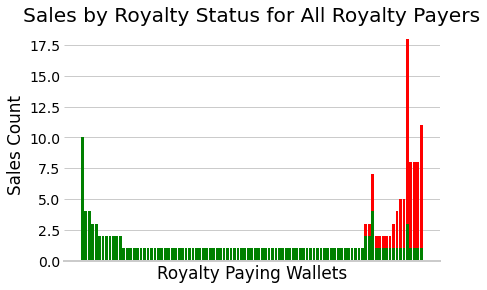

In [40]:
rp_sorted = royalty_payers.sort_values(['full_royalty_rate','full_royalty_sales'],ascending=False)

plt.bar(rp_sorted.address, rp_sorted.full_royalty_sales, color='g')
plt.bar(rp_sorted.address, rp_sorted.non_full_royalty_sales, bottom=rp_sorted.full_royalty_sales, color='r')
plt.xticks([]);
plt.xlabel('Royalty Paying Wallets');
plt.title('Sales by Royalty Status for All Royalty Payers');
plt.ylabel('Sales Count');

In [47]:
sales.loc[sales.paidFullRoyalty,'royaltyFeeBps'].value_counts()

500.0    129
554.0      1
Name: royaltyFeeBps, dtype: int64

In [49]:
sales.royaltyFeeBps.value_counts().sort_index()

1.0         1
24.0        8
25.0        2
42.0       12
49.0        1
50.0      365
99.0       19
100.0      19
115.0       3
116.0       3
140.0       5
164.0       4
169.0       1
190.0      16
198.0       2
249.0       2
250.0       2
271.0       2
277.0       3
333.0       1
350.0       1
393.0       1
500.0     129
554.0       1
1428.0      1
Name: royaltyFeeBps, dtype: int64